In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats
import matplotlib
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

In [2]:
df = pd.read_csv('C:/Users/user/github/Data/energy/train.csv', encoding='cp949')

In [3]:
eda_df = df.copy()

In [4]:
eda_df['month'] = 0
eda_df['hour'] = 0
eda_df['year'] = 0
eda_df['day'] = 0
eda_df['요일'] = 0

In [5]:
eda_df.date_time = pd.to_datetime(eda_df.date_time)

In [6]:
days = {0: '월요일', 1: '화요일', 2: '수요일', 3: '목요일', 4: '금요일', 5: '토요일', 6: '일요일'}

In [7]:
eda_df['month'] = eda_df.date_time.dt.month
eda_df['hour'] = eda_df.date_time.dt.hour
eda_df['year'] = eda_df.date_time.dt.year
eda_df['day'] = eda_df.date_time.dt.day
eda_df['요일'] = eda_df['date_time'].dt.weekday.map(days)

In [8]:
input = eda_df.drop(['기온(°C)','풍속(m/s)','습도(%)','강수량(mm)','일조(hr)','비전기냉방설비운영','태양광보유','month'], axis=1)

In [9]:
mean = pd.DataFrame(input.groupby(['num','요일','hour']).mean()['전력사용량(kWh)'])

In [10]:
std = pd.DataFrame(input.groupby(['num','요일','hour']).std()['전력사용량(kWh)'])

In [11]:
total_df = pd.merge(mean, std, how='inner', left_on = ['num','요일','hour'], right_on=['num','요일','hour'])

In [12]:
total_df.reset_index(inplace=True)

In [13]:
total_df.columns = ['num' ,'요일', 'hour', 'mean', 'std']

In [14]:
class HourlyDataUpdater:
    def __init__(self, hourly_means, hourly_std_devs, alpha=0.1):
        self.hourly_means = hourly_means
        self.hourly_std_devs = hourly_std_devs
        self.alpha = alpha

    def update(self, hour, new_data):
        old_mean = self.hourly_means[hour]
        old_std_dev = self.hourly_std_devs[hour]

        # 평균 업데이트
        new_mean = old_mean * (1 - self.alpha) + new_data * self.alpha

        # 표준편차 업데이트
        new_std_dev = np.sqrt((1 - self.alpha) * (old_std_dev ** 2) + self.alpha * ((new_data - old_mean) ** 2))

        # 값 업데이트
        self.hourly_means[hour] = new_mean
        self.hourly_std_devs[hour] = new_std_dev

        return new_mean

    def predict(self, hour, new_data):
        updated_mean = self.update(hour, new_data)
        return stats.norm(updated_mean, self.hourly_std_devs[hour]).pdf(new_data)

In [15]:
def get_weekday_indices(index):
    datetime_index = pd.DatetimeIndex(index)
    weekday_indices = datetime_index[datetime_index.weekday < 5]
    return weekday_indices

In [16]:
df_1 = df[df['num']==1]

In [17]:
df_1.date_time = pd.to_datetime(df_1.date_time)

In [18]:
df_1 = df_1.set_index(['date_time'])

In [19]:
weekday = get_weekday_indices(df_1.index)

In [20]:
weekday

DatetimeIndex(['2020-06-01 00:00:00', '2020-06-01 01:00:00',
               '2020-06-01 02:00:00', '2020-06-01 03:00:00',
               '2020-06-01 04:00:00', '2020-06-01 05:00:00',
               '2020-06-01 06:00:00', '2020-06-01 07:00:00',
               '2020-06-01 08:00:00', '2020-06-01 09:00:00',
               ...
               '2020-08-24 14:00:00', '2020-08-24 15:00:00',
               '2020-08-24 16:00:00', '2020-08-24 17:00:00',
               '2020-08-24 18:00:00', '2020-08-24 19:00:00',
               '2020-08-24 20:00:00', '2020-08-24 21:00:00',
               '2020-08-24 22:00:00', '2020-08-24 23:00:00'],
              dtype='datetime64[ns]', name='date_time', length=1464, freq=None)

In [21]:
input_1 = df_1.loc[weekday]

In [143]:
input_1.reset_index(inplace=True)

In [148]:
input_1['hour'] = input_1.date_time.dt.hour

In [149]:
input_1

,date_time,num,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,hour
0,2020-06-01 00:00:00,1,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,0
1,2020-06-01 01:00:00,1,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,1
2,2020-06-01 02:00:00,1,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2
3,2020-06-01 03:00:00,1,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,3
4,2020-06-01 04:00:00,1,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...
1459,2020-08-24 19:00:00,1,8714.952,29.4,3.4,66.0,0.0,0.2,0.0,0.0,19
1460,2020-08-24 20:00:00,1,8740.224,28.7,1.9,69.0,0.0,0.0,0.0,0.0,20
1461,2020-08-24 21:00:00,1,8730.504,28.3,1.1,71.0,0.0,0.0,0.0,0.0,21
1462,2020-08-24 22:00:00,1,8725.968,28.3,2.4,72.0,0.0,0.0,0.0,0.0,22


In [152]:
mean = input_1[:24*30].groupby(['hour']).mean()['전력사용량(kWh)']
std = input_1[:24*30].groupby(['hour']).std()['전력사용량(kWh)']

In [154]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [155]:
hourly_means = mean 
hourly_std_devs = std
total_means = []
pred_error_mse = []
pred_error_mae = []

for i in range(30):
    new_data = input_1.iloc[24 * i + 30 * 24 : 24 * (i+1) + 30 * 24, 1]

    updater = HourlyDataUpdater(hourly_means, hourly_std_devs, alpha=0.5)

    updated_means = []
    for hour, data in enumerate(new_data):
        updated_mean = updater.update(hour, data)
        updated_means.append(updated_mean)
    
    pred_error_mse.append(mean_squared_error(new_data, updated_means))
    pred_error_mae.append(mean_absolute_error(new_data, updated_means))
    
    total_means.append(updated_means)

In [156]:
mean_absolute_error(new_data, updated_means)

7.922248728549816e-06

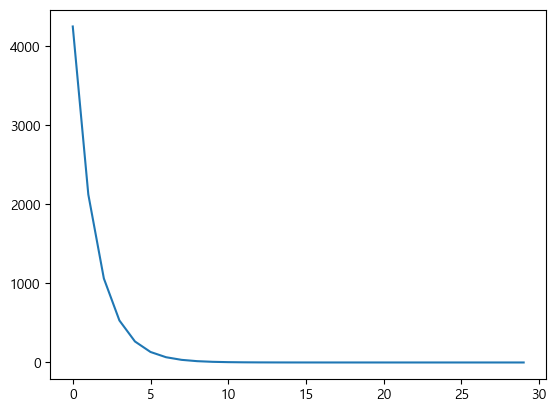

In [163]:
plt.plot(pred_error_mae)

In [158]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf

In [166]:
train_data = input_1[:24*30].iloc[:,2]

In [168]:
test_data = input_1[24*30:].iloc[:,2]

In [169]:
train_data_tf = tf.convert_to_tensor(train_data, dtype=tf.float32)

In [199]:
test_data_tf = tf.convert_to_tensor(test_data, dtype=tf.float32)

In [287]:
# LSTM 모델 정의
lstm_model = Sequential()
lstm_model.add(LSTM(1024, input_shape=(24, 1), return_sequences=True))
lstm_model.add(LSTM(512))
lstm_model.add(Dense(24))
lstm_model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [288]:
window_size = 24
X, y = [], []
for i in range(len(train_data) - window_size * 2): # 24시간의 예측을 위한 조정
    X.append(train_data[i:(i+window_size)])
    y.append(train_data[(i+window_size):(i+window_size*2)]) # 다음 24시간을 타겟으로 설정
X, y = np.array(X), np.array(y)
X = X.reshape(-1, 24, 1)

In [338]:
X.shape

(672, 24, 1)

In [289]:
lstm_model.fit(X, y, epochs=300, batch_size=64, verbose=10)

Epoch 1/300
Epoch 2/300
Epoch 3/300
Epoch 4/300
Epoch 5/300
Epoch 6/300
Epoch 7/300
Epoch 8/300
Epoch 9/300
Epoch 10/300
Epoch 11/300
Epoch 12/300
Epoch 13/300
Epoch 14/300
Epoch 15/300
Epoch 16/300
Epoch 17/300
Epoch 18/300
Epoch 19/300
Epoch 20/300
Epoch 21/300
Epoch 22/300
Epoch 23/300
Epoch 24/300
Epoch 25/300
Epoch 26/300
Epoch 27/300
Epoch 28/300
Epoch 29/300
Epoch 30/300
Epoch 31/300
Epoch 32/300
Epoch 33/300
Epoch 34/300
Epoch 35/300
Epoch 36/300
Epoch 37/300
Epoch 38/300
Epoch 39/300
Epoch 40/300
Epoch 41/300
Epoch 42/300
Epoch 43/300
Epoch 44/300
Epoch 45/300
Epoch 46/300
Epoch 47/300
Epoch 48/300
Epoch 49/300
Epoch 50/300
Epoch 51/300
Epoch 52/300
Epoch 53/300
Epoch 54/300
Epoch 55/300
Epoch 56/300
Epoch 57/300
Epoch 58/300
Epoch 59/300
Epoch 60/300
Epoch 61/300
Epoch 62/300
Epoch 63/300
Epoch 64/300
Epoch 65/300
Epoch 66/300
Epoch 67/300
Epoch 68/300
Epoch 69/300
Epoch 70/300
Epoch 71/300
Epoch 72/300
Epoch 73/300
Epoch 74/300
Epoch 75/300
Epoch 76/300
Epoch 77/300
Epoch 78

In [322]:
lstm_pred_error_mse = []
lstm_pred_error_mae = []
for i in range(30):
    # 테스트 데이터 세그먼트
    test_data_segment = test_data[i * 24 : (i+1) * 24]
    test_data_segment = np.array(test_data_segment).reshape(1, 24, 1)
    
    # 24시간 예측 수행
    predictions = lstm_model.predict(test_data_segment)

    # 오차 계산
    true_value = test_data[(i+1) * 24 : (i+2) * 24] # 다음 24시간의 실제 값
    lstm_mse = mean_squared_error(true_value, predictions[0]*5)
    lstm_mae = mean_absolute_error(true_value, predictions[0]*5)

    lstm_pred_error_mse.append(lstm_mse)
    lstm_pred_error_mae.append(lstm_mae)

1/1 [==============================] - 0s 31ms/step


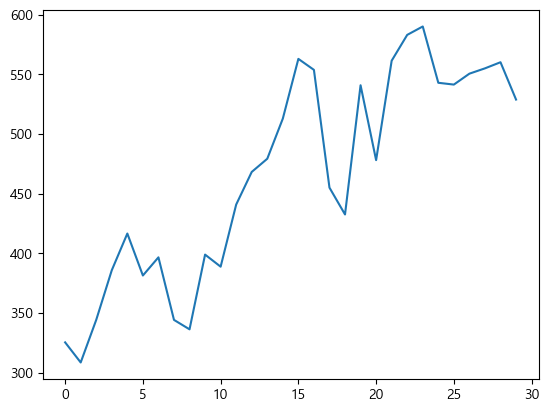

In [325]:
plt.plot(lstm_pred_error_mae)

In [173]:
from sklearn.ensemble import RandomForestRegressor

In [221]:
input_1

,date_time,num,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,hour
0,2020-06-01 00:00:00,1,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,0
1,2020-06-01 01:00:00,1,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,1
2,2020-06-01 02:00:00,1,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2
3,2020-06-01 03:00:00,1,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,3
4,2020-06-01 04:00:00,1,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...
1459,2020-08-24 19:00:00,1,8714.952,29.4,3.4,66.0,0.0,0.2,0.0,0.0,19
1460,2020-08-24 20:00:00,1,8740.224,28.7,1.9,69.0,0.0,0.0,0.0,0.0,20
1461,2020-08-24 21:00:00,1,8730.504,28.3,1.1,71.0,0.0,0.0,0.0,0.0,21
1462,2020-08-24 22:00:00,1,8725.968,28.3,2.4,72.0,0.0,0.0,0.0,0.0,22


In [224]:
train_rf = input_1[:24*30][['date_time', '전력사용량(kWh)']]
test_rf = input_1[24*30:][['date_time', '전력사용량(kWh)']]

In [228]:
train_rf['hour'] = train_rf.date_time.dt.hour
train_rf['month'] = train_rf.date_time.dt.month
train_rf['dayofweek'] = train_rf.date_time.dt.dayofweek

test_rf['hour'] = test_rf.date_time.dt.hour
test_rf['month'] = test_rf.date_time.dt.month
test_rf['dayofweek'] = test_rf.date_time.dt.dayofweek

In [232]:
train_rf_x = train_rf[['hour', 'month', 'dayofweek']]
test_rf_x = test_rf[['hour', 'month', 'dayofweek']]

train_rf_y = train_rf['전력사용량(kWh)']
test_rf_y = test_rf['전력사용량(kWh)']

In [233]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

In [235]:
rf.fit(train_rf_x, train_rf_y)

RandomForestRegressor(random_state=42)

In [241]:
test_rf_x.iloc[24 * 0 : 24 * (0+1) ]

,hour,month,dayofweek
720,0,7,0
721,1,7,0
722,2,7,0
723,3,7,0
724,4,7,0
725,5,7,0
726,6,7,0
727,7,7,0
728,8,7,0
729,9,7,0


In [275]:
rf_pred_error_mse = []
rf_pred_error_mae = []

for i in range(30):
    # 베이지안 업데이트와 동일한 방식으로 테스트 데이터 세트 분리
    test_data_x = test_rf_x.iloc[24 * i: 24 * (i+1)]
    test_data_y = test_rf_y.iloc[24 * i: 24 * (i+1)]

    # 예측 수행
    predictions = rf.predict(test_data_x)

    # 오차 계산
    mse = mean_squared_error(test_data_y, predictions)
    mae = mean_absolute_error(test_data_y, predictions)

    # 오차 저장
    rf_pred_error_mse.append(mse)
    rf_pred_error_mae.append(mae)


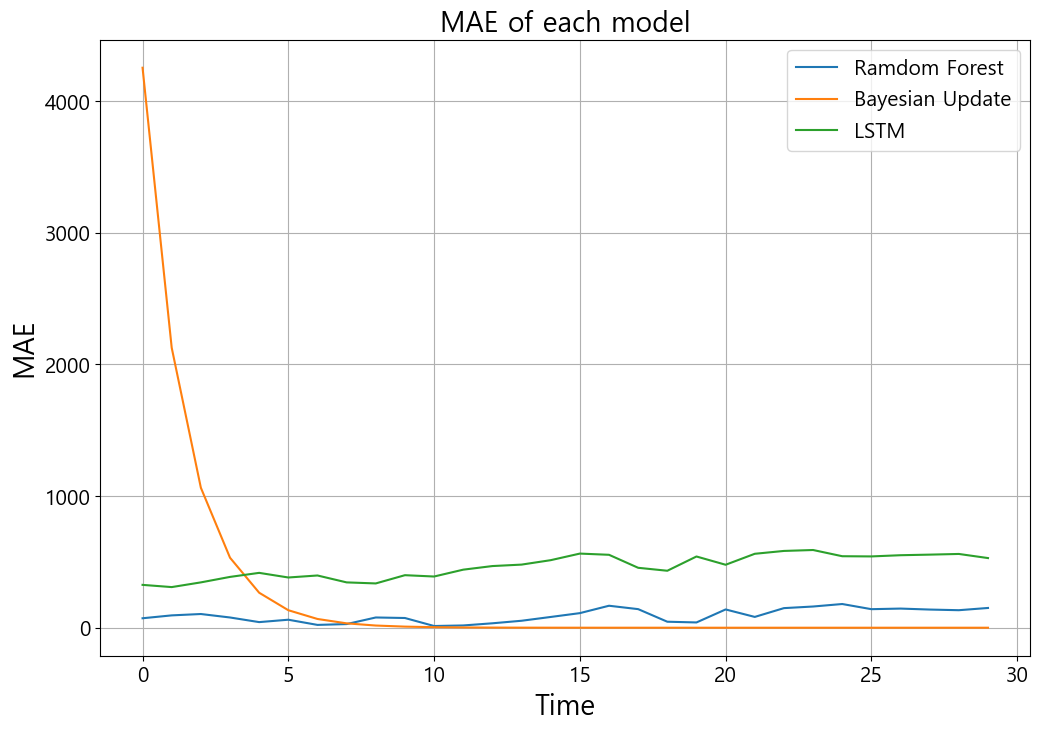

In [336]:
#plt.ylim(0,300)
plt.figure(figsize=(12,8))
plt.plot(rf_pred_error_mae, label = 'Ramdom Forest')
plt.plot(pred_error_mae, label = 'Bayesian Update')
plt.plot(lstm_pred_error_mae, label = 'LSTM')
plt.legend(fontsize = 15)
plt.ylabel('MAE', fontsize = 20)
plt.xlabel('Time', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('MAE of each model', fontsize = 20)
plt.grid()
plt.show()